In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import pgmpy
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete import TabularCPD
from collections import defaultdict
from pgmpy.inference import VariableElimination
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

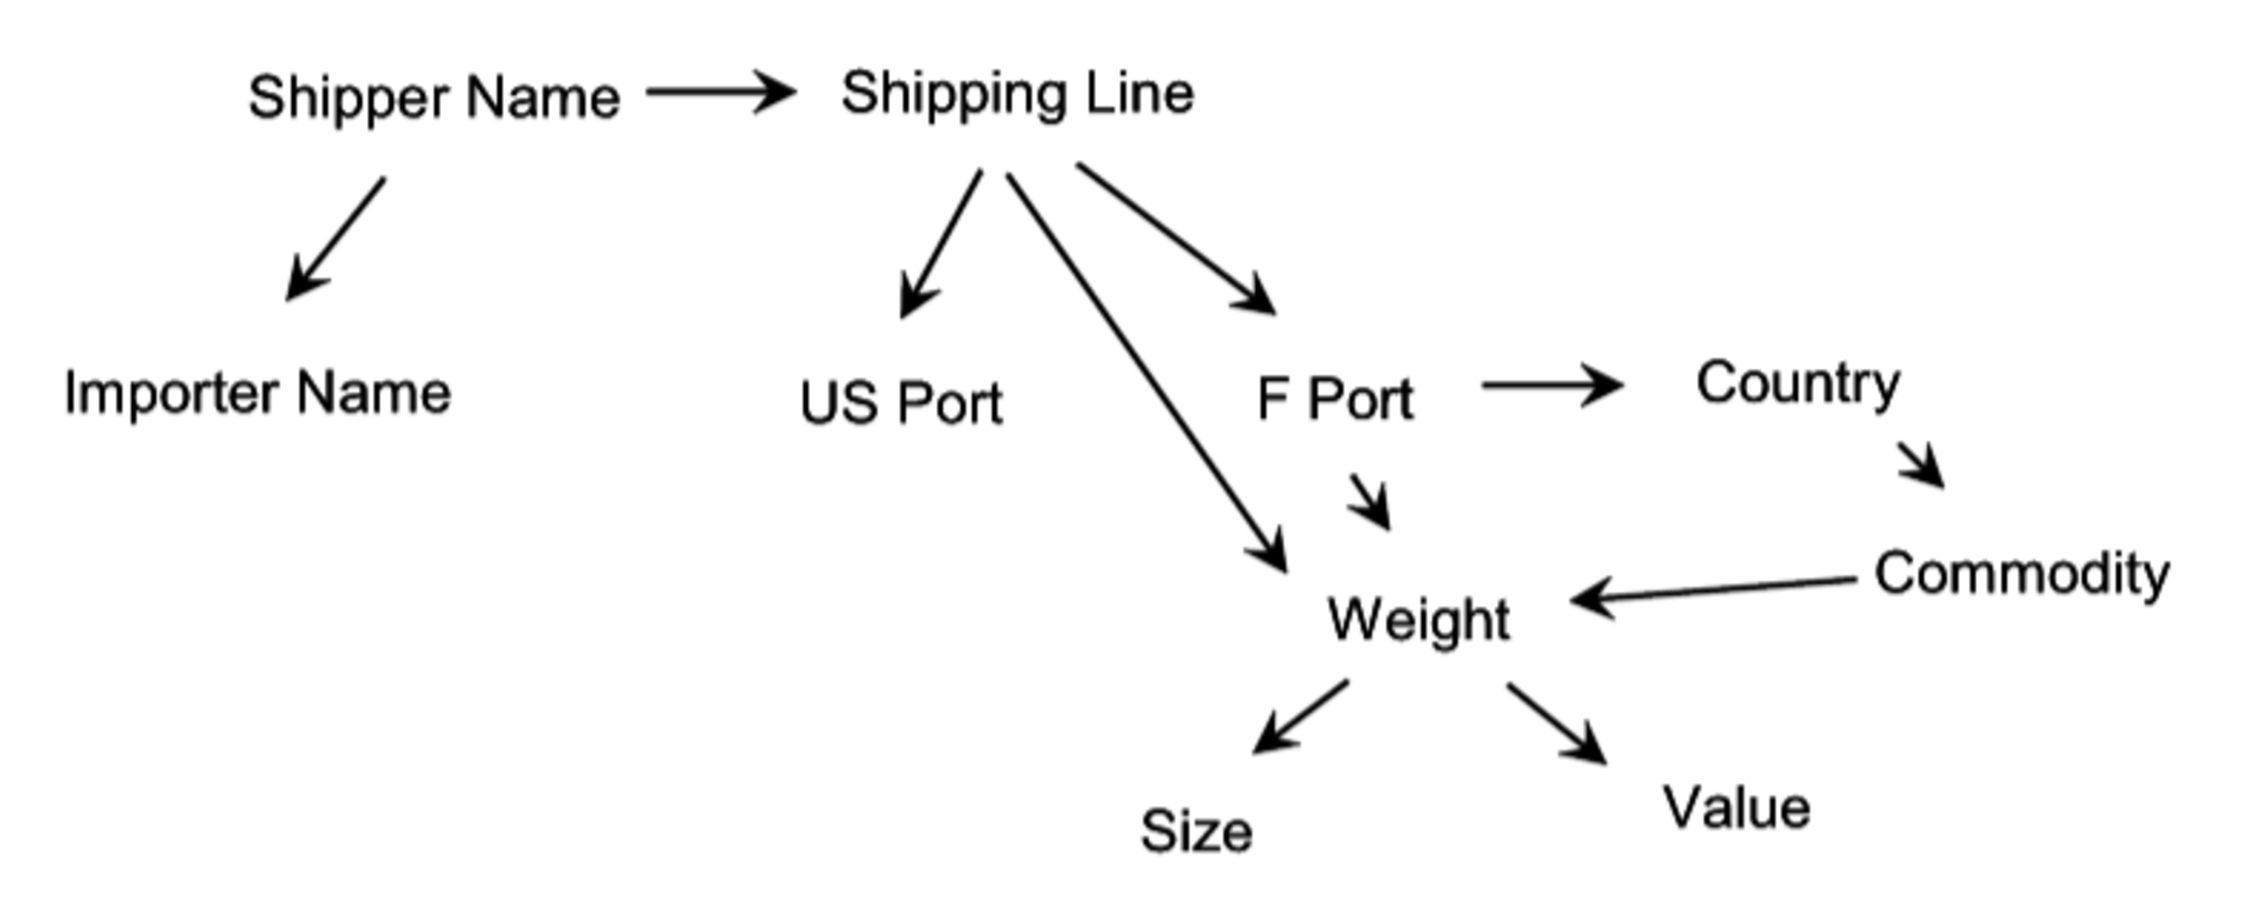

In [2]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

A. CI (Shipper Name, Value | F Port)?

B. CI (Shipper Name, Value | Shipping Line)? 

C. CI (Foreign Port, Commodity | Country)? 

D. CI (Foreign Port, Commodity | County, Weight)? 

**A. Dependent
B. Independent
C. Independent
D. Dependent**

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (70%), ASCO (30%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (80%), Los Angeles (20%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

b) A heavy package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

**a) A heavy package shipped from Vancouver to Seattle by ASCO**
P1 = P(Shipping Line=ASCO) * P(Foreign Port = Vancouver | Shipping Line = ASCO) * P(US Port = Seattle | Shipping Line = ASCO) * P(Weight = Heavy | Shipping Line = ASCO, Foreign Port = Vancouver) = 30% * 100% * 100% * 15% = 4.5%

**b) A heavy package shipped from Vancouver to Seattle by CSCO**
P2 = P(Shipping Line=CSCO) * P(Foreign Port = Vancouver | Shipping Line = CSCO) * P(US Port = Seattle | Shipping Line = CSCO) * P(Weight =Heavy | Shipping Line = CSCO, Foreign Port = Vancouver) = 70% * 60% * 80% * 20% = 6.72%

**c) A heavy package shipped from Yokohama to Los Angeles by CSCO**
P3 = P(Shipping Line=CSCO) * P(Foreign Port = Yokohama | Shipping Line = CSCO) * P(US Port = Los Angeles | Shipping Line = CSCO) * P(Weight =Heavy | Shipping Line = CSCO, Foreign Port = Yokohama) = 70% * 40% * 20% * 60% = 3.36%

**Thus, P3 is the lowest likelihood which is most anomalous.**

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [3]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,0,0,0,1,0,1
2,1,1,0,1,1,1
3,1,0,0,1,1,1
4,2,0,1,0,1,1


a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [4]:
# a)
hc_model = HillClimbSearch(train, scoring_method=BicScore(train))
best_model = hc_model.estimate()
print(best_model.edges())

[('B', 'A'), ('D', 'A'), ('E', 'A')]


In [5]:
# b)
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
print(best_model.local_independencies(best_model.nodes()))

CPD of A:
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| B    | B(0)                 | B(0)                  | B(0)                 | B(0)                 | B(1)                  | B(1)                 | B(1)                  | B(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| D    | D(0)                 | D(0)                  | D(1)                 | D(1)                 | D(0)                  | D(0)                 | D(1)                  | D(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| E    | E

In [6]:
#c)
def temp_predict(model,data):
    missing_variables = list(set(model.nodes()) - set(data.columns))
    pred_values = defaultdict(list)
    model_inference = VariableElimination(model)
    for index, data_point in data.iterrows():
        states_dict = model_inference.map_query(variables=missing_variables, evidence=data_point.astype(int).to_dict())
        for k, v in states_dict.items():
            pred_values[k].append(v)
    return pd.DataFrame(pred_values, index=data.index)

train_x = train.loc[:,"B":"F"]

predicted_train = temp_predict(best_model, train_x)
#print "In sample:",(train.loc[:,'A']==predicted_train['A']).mean()

test_x = test.loc[:,"B":"F"]
predicted_test = temp_predict(best_model, test_x)
print ("Out of sample:",(test.loc[:,'A']==predicted_test['A']).mean())

Out of sample: 0.5645


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

**To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.**

In [7]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


In [8]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


In [9]:
# k-means cluster  k=3
name_ls = ['hour_' + str(i) for i in range(0,24)] 
hour_data = data3[name_ls]
kmeans = KMeans(n_clusters = 3, random_state= 2019)
fit_kmeans = kmeans.fit(hour_data)
data3['kmeans_lable'] = fit_kmeans.labels_
hour_data['kmeans_lable'] = fit_kmeans.labels_

/Users/xiaoguihua/anaconda3/envs/gabriel/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [10]:
hour_data.head()

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,kmeans_lable
0,0.073654,0.079320,0.076487,0.087819,0.082153,0.073654,0.039660,0.033994,0.014164,0.016997,...,0.019830,0.025496,0.022663,0.022663,0.053824,0.033994,0.033994,0.042493,0.062323,1
1,0.055556,0.070370,0.033333,0.014815,0.025926,0.003704,0.007407,0.014815,0.018519,0.029630,...,0.077778,0.048148,0.059259,0.044444,0.044444,0.077778,0.044444,0.074074,0.044444,1
2,0.040630,0.039580,0.033275,0.036778,0.018564,0.014011,0.012609,0.021366,0.025569,0.034676,...,0.052189,0.059895,0.056392,0.062347,0.051839,0.053240,0.066550,0.055692,0.056042,1
3,0.034000,0.026000,0.018000,0.009000,0.010000,0.015000,0.020000,0.017000,0.033000,0.036000,...,0.058000,0.073000,0.078000,0.068000,0.066000,0.059000,0.038000,0.051000,0.041000,1
4,0.009804,0.009804,0.029412,0.009804,0.009804,0.019608,0.039216,0.019608,0.000000,0.029412,...,0.009804,0.107843,0.117647,0.058824,0.068627,0.078431,0.068627,0.049020,0.088235,1


**a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster. (5 pts)**

In [11]:
cluster_hour_mean = hour_data.groupby(['kmeans_lable']).mean()
cluster_hour_mean

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
kmeans_lable,,,,,,,,,,,,,,,,,,,,,
0,0.043245,0.013720,0.012789,0.011170,0.010658,0.009248,0.014287,0.027264,0.049033,0.083252,...,0.062267,0.069033,0.062868,0.055131,0.051366,0.043632,0.035290,0.027024,0.024164,0.020630
1,0.054957,0.043446,0.039060,0.032576,0.025870,0.019241,0.019732,0.022155,0.025810,0.031555,...,0.039423,0.044377,0.049516,0.052590,0.056821,0.056824,0.062139,0.058006,0.062217,0.055101
2,0.024007,0.016365,0.009117,0.004741,0.002911,0.001163,0.003572,0.009699,0.013942,0.027160,...,0.060560,0.045779,0.041353,0.044839,0.074194,0.105416,0.083005,0.073867,0.061552,0.036855


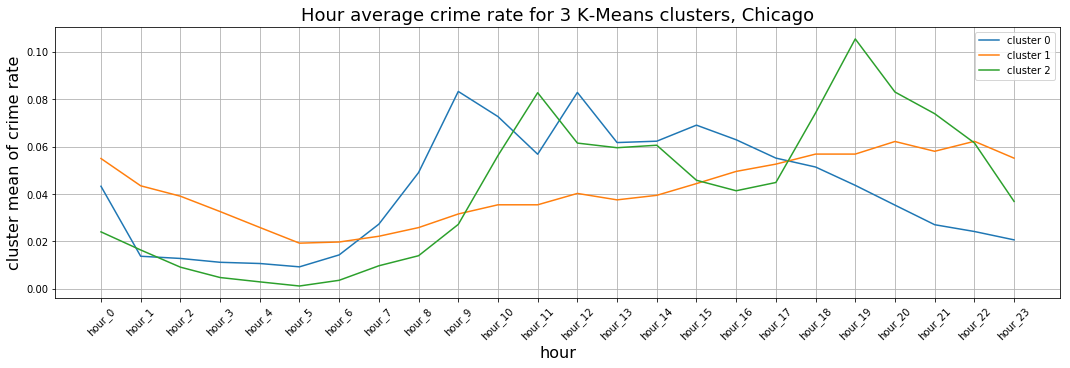

In [12]:
#draw the plot
ax = plt.figure(figsize = (18,5))
plt.plot(cluster_hour_mean.loc[0], label = 'cluster 0')
plt.plot(cluster_hour_mean.loc[1], label = 'cluster 1')
plt.plot(cluster_hour_mean.loc[2], label = 'cluster 2')
plt.grid(b=True)
plt.legend(loc = 'upper right')
plt.title('Hour average crime rate for 3 K-Means clusters, Chicago', fontsize=18)
plt.xlabel('hour',fontsize=16)
plt.ylabel('cluster mean of crime rate', fontsize=16)
plt.xticks(rotation=45)
plt.show()

Fig.1 :  This is the line graph for Chicago mean crime rate of 3 K-means clusters. Data is shown in hourly base. 

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

**1. from hour 23 to 6 in the following day, all three clusters have the relative lower average hourly crime rate.**

**2. cluser 1 has a smoother line (smaller increase/decrease of average crime rate) than others**

**3. Although there are both two peaks in cluster 0 and 2. The time the peaks appeared are different: for cluster 0, the peaks are at hour9 and hour 12 while for cluster 2, the peaks are at hour11 and hour 19.**

c) Do you notice any consistent trends about which crime types are assigned to which cluster? Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)

In [13]:
data3.groupby(['kmeans_lable','crime_type'])['Category'].count()

kmeans_lable  crime_type                                                  
0             ASSAULT: PRO EMP HANDS NO/MIN INJURY                            1
              ASSAULT: SIMPLE                                                 1
              BATTERY: AGG: HANDS/FIST/FEET NO/MINOR INJURY                   1
              BATTERY: PRO EMP HANDS NO/MIN INJURY                            1
              BURGLARY: FORCIBLE ENTRY                                        1
              BURGLARY: UNLAWFUL ENTRY                                        1
              CRIMINAL TRESPASS: TO STATE SUP LAND                            1
              DECEPTIVE PRACTICE: ATTEMPT - FINANCIAL IDENTITY THEFT          1
              DECEPTIVE PRACTICE: BOGUS CHECK                                 1
              DECEPTIVE PRACTICE: COUNTERFEIT CHECK                           1
              DECEPTIVE PRACTICE: CREDIT CARD FRAUD                           1
              DECEPTIVE PRACTICE: FINANCIAL I

**From the output above, we could summarize that cluster 0 has assault, deceptive practice, and other. Cluster 1 is mainly composed of theft and weapon violations while cluster 2 has narcotics and otehr offense (gun related, license, and sex offender).**

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

In [14]:
data3.shape

(119, 111)

In [15]:
day_data = data3.iloc[:,[2,3,4,5,6,7,8,110]]
#date_data.head()
cluster_day_mean = day_data.groupby(['kmeans_lable']).mean()
cluster_day_mean

,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat
kmeans_lable,,,,,,,
0,0.112090,0.150071,0.152745,0.150216,0.152279,0.157143,0.125456
1,0.148421,0.136530,0.138077,0.135497,0.136308,0.149824,0.155342
2,0.116685,0.149805,0.156719,0.147544,0.145351,0.156398,0.127497


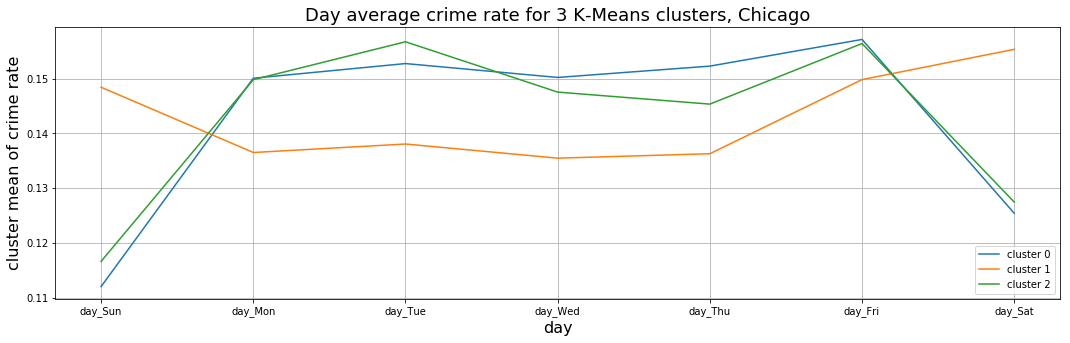

In [16]:
#draw the plot
ax = plt.figure(figsize = (18,5))
plt.plot(cluster_day_mean.loc[0], label = 'cluster 0')
plt.plot(cluster_day_mean.loc[1], label = 'cluster 1')
plt.plot(cluster_day_mean.loc[2], label = 'cluster 2')
plt.grid(b=True)
plt.legend(loc = 'lower right')
plt.title('Day average crime rate for 3 K-Means clusters, Chicago', fontsize=18)
plt.xlabel('day',fontsize=16)
plt.ylabel('cluster mean of crime rate', fontsize=16)
plt.show()

Fig. 2 :  This is the line graph for Chicago mean crime rate of 3 K-means clusters. Data is shown in daily base. 

**Notable difference: Those three clusters have 2 types of different patterns. We could see that on Mon-Thu cluster 1 has a lower mean crime rate while cluster 0 and 2 have higher ones. For Fri - Sun, cluster 1 has higher mean rate while cluster 0 and 2 has higher ones**

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

In [17]:
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77,kmeans_lable
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833,1
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407,1
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152,1
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000,1
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000,1


In [18]:
community_data = data3.loc[:,'community_area_1':'kmeans_lable']
cluster_com_mean = community_data.groupby(['kmeans_lable']).mean()
cluster_com_mean

,community_area_1,community_area_2,community_area_3,community_area_4,community_area_5,community_area_6,community_area_7,community_area_8,community_area_9,community_area_10,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
kmeans_lable,,,,,,,,,,,,,,,,,,,,,
0,0.014488,0.013502,0.016262,0.010105,0.006886,0.025938,0.016826,0.053181,0.001884,0.007328,...,0.018165,0.022639,0.009606,0.025028,0.004788,0.011602,0.003728,0.009214,0.014795,0.012170
1,0.013995,0.012911,0.013156,0.007072,0.004093,0.018733,0.009981,0.025083,0.000689,0.003313,...,0.027145,0.028373,0.009527,0.028696,0.002866,0.010997,0.001618,0.007003,0.007500,0.006890
2,0.008226,0.005906,0.008449,0.003058,0.001272,0.010135,0.002238,0.015706,0.000401,0.001440,...,0.037301,0.028304,0.002517,0.033078,0.000939,0.010416,0.000630,0.007184,0.000964,0.002171


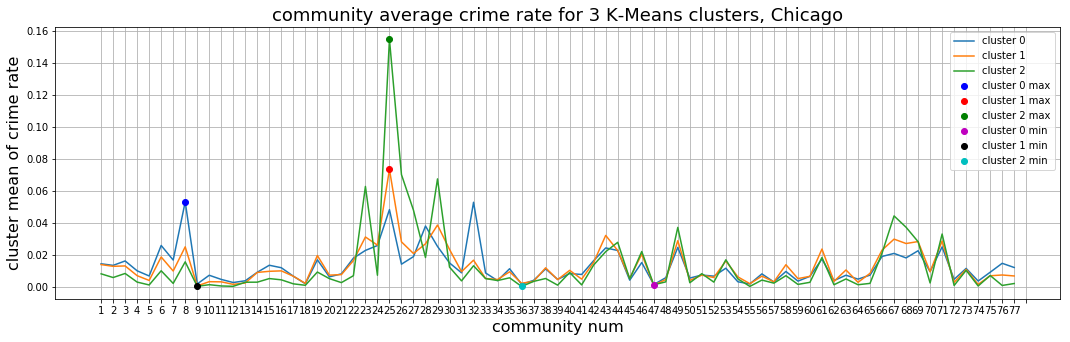

In [19]:
#draw the plot
ax = plt.figure(figsize = (18,5))
plt.plot(cluster_com_mean.loc[0], label = 'cluster 0')
plt.plot(cluster_com_mean.loc[1], label = 'cluster 1')
plt.plot(cluster_com_mean.loc[2], label = 'cluster 2')

#get the max value:
max_point_c0 = plt.plot(cluster_com_mean.loc[0].idxmax(), max(cluster_com_mean.loc[0]), 'bo', label="cluster 0 max")
max_point_c1 = plt.plot(cluster_com_mean.loc[1].idxmax(), max(cluster_com_mean.loc[1]), 'ro', label="cluster 1 max")
max_point_c2 = plt.plot(cluster_com_mean.loc[2].idxmax(), max(cluster_com_mean.loc[2]), 'go', label="cluster 2 max")

#label the min value
min_point_c0 = plt.plot(cluster_com_mean.loc[0].idxmin(), min(cluster_com_mean.loc[0]), 'mo', label="cluster 0 min")
min_point_c1 = plt.plot(cluster_com_mean.loc[1].idxmin(), min(cluster_com_mean.loc[1]), 'ko', label="cluster 1 min")
min_point_c2 = plt.plot(cluster_com_mean.loc[2].idxmin(), min(cluster_com_mean.loc[2]), 'co', label="cluster 2 min")

plt.grid(b=True)
plt.legend(loc = 'upper right')
plt.title('community average crime rate for 3 K-Means clusters, Chicago', fontsize=18)
plt.xlabel('community num',fontsize=16)
plt.xticks(range(0,78),range(1,78))
plt.ylabel('cluster mean of crime rate', fontsize=16)
plt.show()

Fig. 2 :  This is the line graph for Chicago mean crime rate of 3 K-means clusters. Data is shown in the categories of communities in Chicago. 

**From the plot above, we could see that the minimums of each type are all very small. Thus, in this case, we will only focus on the max 5 values of each cluster**

In [38]:
cluster_com_mean.loc[0].nlargest(5)

community_area_8     0.053181
community_area_32    0.052905
community_area_25    0.048313
community_area_28    0.038063
community_area_6     0.025938
Name: 0, dtype: float64

In [39]:
cluster_0_demo = data4.loc[data4['Community Area Number'].isin([8,32,25,28,6])]
cluster_0_demo.loc['mean'] = data4.mean()
cluster_0_demo

/Users/xiaoguihua/anaconda3/envs/gabriel/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
5,6.0,Lake View,1.169109e+06,1.922712e+06,1.100000,11.400000,4.700000,2.600000,17.000000,60058.000000,8.573972,5671.000000
7,8.0,Near North Side,1.175512e+06,1.906089e+06,1.900000,12.900000,7.000000,2.500000,22.600000,88669.000000,17.077160,9847.000000
24,25.0,Austin,1.140839e+06,1.903174e+06,6.300000,28.600000,22.600000,24.400000,37.900000,15957.000000,14.188517,15719.000000
27,28.0,Near West Side,1.167030e+06,1.898360e+06,3.800000,20.600000,10.700000,9.600000,22.200000,44689.000000,11.790159,8891.000000
31,32.0,Loop,1.176374e+06,1.899831e+06,1.500000,14.700000,5.700000,3.100000,13.500000,65526.000000,24.629080,8471.000000
mean,39.0,NaN,1.163753e+06,1.884761e+06,4.923377,21.766234,15.372727,20.341558,35.746753,25563.168831,12.442935,3262.246753


In [40]:
cluster_com_mean.loc[1].nlargest(5)

community_area_25    0.073436
community_area_29    0.038699
community_area_43    0.032218
community_area_23    0.031227
community_area_67    0.029887
Name: 1, dtype: float64

In [43]:
cluster_1_demo = data4.loc[data4['Community Area Number'].isin([25,29,43,23,67])]
cluster_1_demo.loc['mean'] = data4.mean()
cluster_1_demo

/Users/xiaoguihua/anaconda3/envs/gabriel/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
22,23.0,Humboldt park,1.151216e+06,1.906926e+06,14.800000,33.900000,17.300000,35.400000,38.000000,13781.000000,15.839488,7522.000000
24,25.0,Austin,1.140839e+06,1.903174e+06,6.300000,28.600000,22.600000,24.400000,37.900000,15957.000000,14.188517,15719.000000
28,29.0,North Lawndale,1.152306e+06,1.892569e+06,7.400000,43.100000,21.200000,27.600000,42.700000,12034.000000,21.888178,8073.000000
42,43.0,South Shore,1.191640e+06,1.856742e+06,2.800000,31.100000,20.000000,14.000000,35.700000,19398.000000,18.541882,7673.000000
66,67.0,West Englewood,1.166461e+06,1.861782e+06,4.800000,34.400000,35.900000,26.300000,40.700000,11317.000000,22.388616,6442.000000
mean,39.0,NaN,1.163753e+06,1.884761e+06,4.923377,21.766234,15.372727,20.341558,35.746753,25563.168831,12.442935,3262.246753


In [42]:
cluster_com_mean.loc[2].nlargest(5)

community_area_25    0.154636
community_area_26    0.070156
community_area_29    0.067504
community_area_23    0.062792
community_area_27    0.047951
Name: 2, dtype: float64

In [35]:
cluster_2_demo = data4.loc[data4['Community Area Number'].isin([25,26,29,23,27])]
cluster_2_demo.loc['mean'] = data4.mean()
cluster_2_demo

/Users/xiaoguihua/anaconda3/envs/gabriel/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
22,23.0,Humboldt park,1.151216e+06,1.906926e+06,14.800000,33.900000,17.300000,35.400000,38.000000,13781.000000,15.839488,7522.000000
24,25.0,Austin,1.140839e+06,1.903174e+06,6.300000,28.600000,22.600000,24.400000,37.900000,15957.000000,14.188517,15719.000000
25,26.0,West Garfield Park,1.148755e+06,1.898786e+06,9.400000,41.700000,25.800000,24.500000,43.600000,10934.000000,27.504936,5340.000000
26,27.0,East Garfield Park,1.155087e+06,1.898653e+06,8.200000,42.400000,19.600000,21.300000,43.200000,12961.000000,19.899589,4727.000000
28,29.0,North Lawndale,1.152306e+06,1.892569e+06,7.400000,43.100000,21.200000,27.600000,42.700000,12034.000000,21.888178,8073.000000
mean,39.0,NaN,1.163753e+06,1.884761e+06,4.923377,21.766234,15.372727,20.341558,35.746753,25563.168831,12.442935,3262.246753


**According to the outputs above, we could notice that, there is no noticeable demographic character that has impact on the higher crime rate for cluster 0. However, when refering Chicago community map, we could see that all those communities are located near loop area. High population mobility could be a reason for higher assault and a various range of other crime
For cluster 1 and 2,  we could notice that those communities have higher % of household below poverty, higher % of aged 16+ unemployed and higher % aged 25+ without high school diploma. These characters indicates that poverty and lower education rate could be the cause of higher crime rate of those two types.**

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

In [26]:
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77,kmeans_lable
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833,1
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407,1
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152,1
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000,1
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000,1


In [27]:
fbi_data = data3[['Category','kmeans_lable']]
for i in range(0,3):
    print('for cluster %d' %i)
    print(fbi_data[fbi_data['kmeans_lable']==i].Category.value_counts())
    print(fbi_data[fbi_data['kmeans_lable']==i].Category.value_counts(normalize=True))
    print('\n')
    

for cluster 0
P2     27
P1P     6
Name: Category, dtype: int64
P2     0.818182
P1P    0.181818
Name: Category, dtype: float64


for cluster 1
P2     30
P1V    24
P1P     9
Name: Category, dtype: int64
P2     0.476190
P1V    0.380952
P1P    0.142857
Name: Category, dtype: float64


for cluster 2
P2    23
Name: Category, dtype: int64
P2    1.0
Name: Category, dtype: float64




**The output above shows the FBI division vs k-means clusters. I reported the evaluation result in both raw number and proportion.**

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)

In [84]:
cluster_data = data3.loc[:,"day_Sun":"day_Sat"]

**i) kmeans**

In [85]:
cluster_num = {}
for n_clusters in range(2,15):
    clusterer = KMeans(random_state=2019, n_clusters=n_clusters)
    preds = clusterer.fit_predict(cluster_data)
    #centers = clusterer.cluster_centers_

    score = silhouette_score (cluster_data, preds)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    cluster_num[n_clusters] = score

For n_clusters = 2, silhouette score is 0.23496703980224035)
For n_clusters = 3, silhouette score is 0.2170707092848789)
For n_clusters = 4, silhouette score is 0.21069067164506383)
For n_clusters = 5, silhouette score is 0.23963777889548413)
For n_clusters = 6, silhouette score is 0.16837698750520275)
For n_clusters = 7, silhouette score is 0.16551561606187828)
For n_clusters = 8, silhouette score is 0.1616172355424342)
For n_clusters = 9, silhouette score is 0.16540005362281013)
For n_clusters = 10, silhouette score is 0.19490299265812444)
For n_clusters = 11, silhouette score is 0.15689913324683424)
For n_clusters = 12, silhouette score is 0.15378006761656945)
For n_clusters = 13, silhouette score is 0.13716502195221592)
For n_clusters = 14, silhouette score is 0.14806278269182568)


In [86]:
kmeans_cl = KMeans(n_clusters = 5, random_state= 2019)
fit_kmeans = kmeans_cl.fit(cluster_data)
kmeans_data = cluster_data.copy()
kmeans_data['kmeans_lable'] = fit_kmeans.labels_

print ("\n The cluster number for k-means is: %d, distribution of each category is: " %max(cluster_num, key=cluster_num.get))
print (kmeans_data['kmeans_lable'].value_counts())


 The cluster number for k-means is: 5, distribution of each category is: 
0    64
2    34
1    15
4     4
3     2
Name: kmeans_lable, dtype: int64


**ii) Gaussian mixture models** 

In [88]:
cluster_num = {}
for n_clusters in range(2,15):
    clusterer = GaussianMixture(random_state=2019, n_components=n_clusters)
    preds = clusterer.fit_predict(cluster_data)
    #centers = clusterer.cluster_centers_

    score = silhouette_score (cluster_data, preds)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    cluster_num[n_clusters] = score


For n_clusters = 2, silhouette score is 0.25672726757004694)
For n_clusters = 3, silhouette score is 0.2915175983585487)
For n_clusters = 4, silhouette score is 0.20888623831120867)
For n_clusters = 5, silhouette score is 0.14211418651280705)
For n_clusters = 6, silhouette score is 0.09089857858585278)
For n_clusters = 7, silhouette score is 0.08945604231530921)
For n_clusters = 8, silhouette score is 0.11111940916902181)
For n_clusters = 9, silhouette score is 0.10600228790033862)
For n_clusters = 10, silhouette score is 0.08817708176176861)
For n_clusters = 11, silhouette score is 0.1109065325289574)
For n_clusters = 12, silhouette score is 0.12165786609897007)
For n_clusters = 13, silhouette score is 0.1003003917766865)
For n_clusters = 14, silhouette score is 0.10736550689521662)


In [90]:
gmm = GaussianMixture(random_state=2019, n_components=3)
fit_gmm = gmm.fit_predict(cluster_data)


gmm_data = cluster_data.copy()
gmm_data['gmm_lable'] = fit_gmm

print ("\n The cluster number for Gaussian Mixture is: %d, distribution of each category is: " %max(cluster_num, key=cluster_num.get))
print (gmm_data['gmm_lable'].value_counts())


 The cluster number for Gaussian Mixture is: 3
0    84
1    18
2    17
Name: gmm_lable, dtype: int64


**iii) Bottom-up hierarchical clustering with "single link" distance metric**

In [96]:
Z_single = linkage(cluster_data, 'single')
cluster_num = {}
for n_clusters in range(2,15):
    preds = fcluster(Z_single, n_clusters, criterion='maxclust')

    score = silhouette_score (cluster_data, preds)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    cluster_num[n_clusters] = score



For n_clusters = 2, silhouette score is 0.6377648080667613)
For n_clusters = 3, silhouette score is 0.5568477382969328)
For n_clusters = 4, silhouette score is 0.40557775075981567)
For n_clusters = 5, silhouette score is 0.38770381887486705)
For n_clusters = 6, silhouette score is 0.3900761951022192)
For n_clusters = 7, silhouette score is 0.3462184482039438)
For n_clusters = 8, silhouette score is 0.32899815764355905)
For n_clusters = 9, silhouette score is 0.32542192748924165)
For n_clusters = 10, silhouette score is 0.3132151039050357)
For n_clusters = 11, silhouette score is 0.21831462782301697)
For n_clusters = 12, silhouette score is 0.15913660974826932)
For n_clusters = 13, silhouette score is 0.08885073202230036)
For n_clusters = 14, silhouette score is 0.034192948060948976)


In [97]:
sl_label=fcluster(Z_single, 2, criterion='maxclust') 
sl_data=cluster_data.copy()
sl_data['sl_label'] = sl_label

print ("\n The cluster number for Single link is: %d, distribution of each category is: " %max(cluster_num, key=cluster_num.get))
print (sl_data['sl_label'].value_counts())


 The cluster number for Single link is: 2
1    118
2      1
Name: sl_label, dtype: int64


**iv) Bottom-up hierarchical clustering with "complete link" distance metric**

In [34]:
Z_complete = linkage(cluster_data, 'complete')
cluster_num = {}
for n_clusters in range(2,15):
    preds = fcluster(Z_complete, n_clusters, criterion='maxclust')

    score = silhouette_score (cluster_data, preds)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    cluster_num[n_clusters] = score



For n_clusters = 2, silhouette score is 0.6100646113547021)
For n_clusters = 3, silhouette score is 0.17268718146566117)
For n_clusters = 4, silhouette score is 0.19215169374768618)
For n_clusters = 5, silhouette score is 0.15025207822499775)
For n_clusters = 6, silhouette score is 0.15229681572228093)
For n_clusters = 7, silhouette score is 0.14926267616109448)
For n_clusters = 8, silhouette score is 0.10130440123428043)
For n_clusters = 9, silhouette score is 0.10066503899164778)
For n_clusters = 10, silhouette score is 0.1106113243154708)
For n_clusters = 11, silhouette score is 0.1253714185643158)
For n_clusters = 12, silhouette score is 0.11418383303622578)
For n_clusters = 13, silhouette score is 0.11216165708562796)
For n_clusters = 14, silhouette score is 0.10909628423478156)

 The cluster number for Complete link is: 2


In [98]:
cl_label=fcluster(Z_complete, 2, criterion='maxclust') 
cl_data=cluster_data.copy()
cl_data['cl_label'] = cl_label
print ("\n The cluster number for Complete link is: %d" %max(cluster_num, key=cluster_num.get))
print (cl_data['cl_label'].value_counts())


 The cluster number for Complete link is: 2
2    117
1      2
Name: cl_label, dtype: int64


**We can see that complete link and single link clusters has similar cluster output. They both have two categories (one of them has almost all elements in the datasets). In this case, since we did not prune out link, at the final stage, the bottom up hierarchical clustering (both types) will have similar output.**